## Decision Tree and Random Forest
In this laboratory, we will explore two powerful and widely used machine learning techniques: Decision Trees and Random Forests. These models are foundational in supervised learning and have broad applications, from classification and regression to feature selection and ensemble learning.

The primary objective of this laboratory is to gain a deep understanding of how these models work by implementing them from scratch. Rather than relying on existing machine learning libraries, we will develop the core algorithms step-by-step.

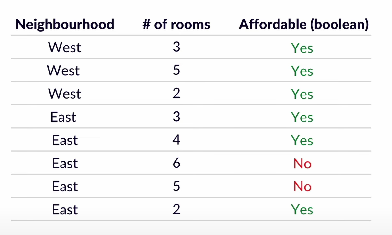
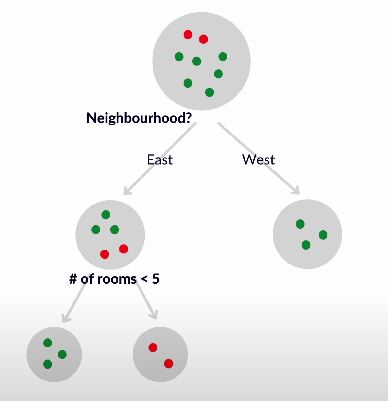

1. Based on what do we choose the spliting feature?

2. How do I choose the split point (5 for the number of rooms)?

3. When to stop splitting?

Information gain and Entropy
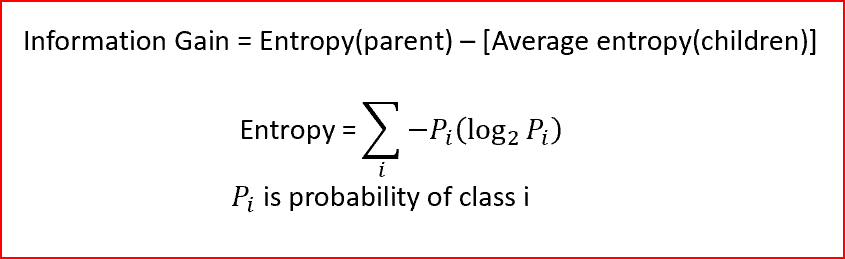
Stopping criteria: maximum depth, minimum number of samples



Steps of the algorithm:
1. Calculate information gain with each possible split
2. Divide set with that feature and value that gives the most information gain
3. Divede tree and do the same for all created branches until a stopping criteria is reached

## How do we test a given data point with our decision tree?
To determine the prediction for a given data point, we traverse the decision tree starting from the root node and following the appropriate branches based on the feature values. This process continues until we reach a leaf node. If the leaf node represents a specific class, we return that class as the prediction. Otherwise, we return the majority class from the leaf node.

## Node Class implementation details

The Node class represents a single node in the decision tree.

feature: The feature index used for splitting at this node

threshold: The threshold value for splitting the data

left and right: References to the left and right child nodes, respectively

value: The predicted class if this is a leaf node

is_leaf_node(): Checks if the node is a leaf node by determining if the value attribute is set.

In [1]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

## Decision Tree implementation details

Parameters:

min_samples_split: The minimum number of samples required to split a node. This prevents overfitting by stopping the tree from growing too deeply on small datasets

max_depth: The maximum depth of the tree. This also helps prevent overfitting by limiting the tree size

n_features: The number of features to consider for splitting at each node. If not specified, the default is to use all features

root: Initially set to None, this will hold the root node of the constructed tree after training

In [2]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    # recursively build the decision tree by splitting the dataset at each node
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        

## Dataset used for testing 
https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

Other toy datasets that you can test can be found here: https://scikit-learn.org/1.5/datasets/toy_dataset.html

### TODO 1) Implement the accuracy method and test the decision tree model on "digits" dataset

In [3]:
def accuracy(y_true, y_pred):
    # TODO
    return np.sum(y_true == y_pred) / len(y_true)

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_digits()
X = data.data
y = data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=17)

tree = DecisionTree(min_samples_split=5, max_depth=10)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)


acc = accuracy(y_test, predictions)
print(acc)

0.7941176470588235


## Random Forest implementation details
Parameters:

n_trees: The number of decision trees in the forest

max_depth: The maximum depth allowed for each decision tree

min_samples_split: The minimum number of samples required to split a node in each tree

n_features: The number of features to consider for splitting in each tree 

trees: A list to hold the individual DecisionTree instances created during training

### TODO 2) Implement the missing methods in order to complete the implementation for RandomForest


In [5]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        
        """
        Initialize the trees list to store trained decision trees.
        For each tree:
            1 Create a new DecisionTree instance with the specified parameters 
            2 Generate a bootstrap sample of the dataset using the _bootstrap_samples method
            3 Train the decision tree on the bootstrap sample
            4 Append the trained tree to the trees list
        """

        # TODO

        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.n_features,
            )
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    # generate a bootstrap sample of the dataset by randomly sampling with replacement
    def _bootstrap_samples(self, X, y):
        """
        Determine the number of samples in the dataset. Choose a random number, n_samples, smaller or equal to the number of samples in the dataset
        Use np.random.choice to randomly sample n_samples indices with replacement (replace=True)
        Return the sampled feature matrix and corresponding labels 
        """
        
        # TODO

        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    #  identifies the majority class in a set of predictions
    def _most_common_label(self, y):
        """
        Use Counter from the collections module to count the occurrences of each label
        Return the most frequent label
        """
        
        # TODO
        
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [6]:
# TODO - test the RandomForest model on the same data as before
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_digits()
X = data.data
y = data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=17)

forest = RandomForest(n_trees=17, max_depth=17, min_samples_split=7, n_feature=None)
forest.fit(X_train, y_train)

predictions = forest.predict(X_test)
acc = accuracy(y_test, predictions)
print(acc)

0.8942766295707473


## TODO 3) Test 5 values for n_trees and plot the obtained values for accuracy. 

n_trees=5, Accuracy: 0.8386327503974563
n_trees=7, Accuracy: 0.8672496025437202
n_trees=12, Accuracy: 0.8799682034976153
n_trees=17, Accuracy: 0.895866454689984
n_trees=19, Accuracy: 0.8966613672496025


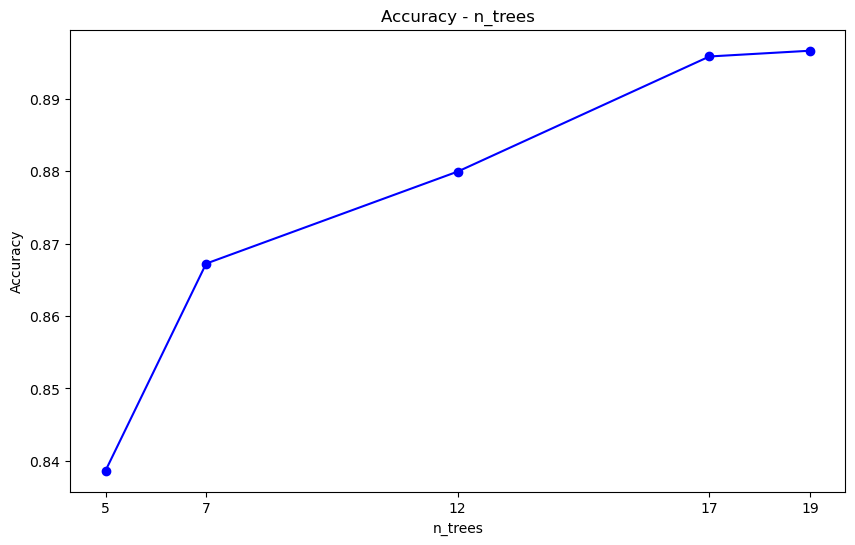

In [10]:
#TODO

import matplotlib.pyplot as plt

n_trees_values = [5, 7, 12, 17, 19]
accuracies = []

for n_trees in n_trees_values:
    forest = RandomForest(n_trees=n_trees, max_depth=17, min_samples_split=7, n_feature=None)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    acc = accuracy(y_test, predictions)
    accuracies.append(acc)
    print(f"n_trees={n_trees}, Accuracy: {acc}")

plt.figure(figsize=(10, 6))
plt.plot(n_trees_values, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Accuracy - n_trees')
plt.xlabel('n_trees')
plt.ylabel('Accuracy')
plt.xticks(n_trees_values)
plt.grid(False)
plt.show()
